In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
application_train = pd.read_csv('application_train.csv')

print(application_train.shape)
application_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
application_test = pd.read_csv('application_test.csv')

print(application_test.shape)
application_test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
y = application_train['TARGET']
train = application_train[[col for col in application_train.columns if col != 'TARGET']]
test = application_test
SK_ID_CURR = test['SK_ID_CURR']

print('train:',train.shape)
print('test:',test.shape)

train: (307511, 121)
test: (48744, 121)


In [5]:
X_total = pd.concat([train, test], axis=0)

print('X_total:',X_total.shape)
print('null:',X_total.isnull().sum().sum())
X_total.head()

X_total: (356255, 121)
null: 10556884


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
bureau = pd.read_csv('bureau.csv')

print(bureau.shape)
bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [7]:
# 1つのSK_ID_CURRに対する、BUREAU_IDの数を調べる
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'] \
                                    .count().rename(columns={'SK_ID_BUREAU':'previous_loan_counts'})

print(previous_loan_counts.shape)
previous_loan_counts.head()

(305811, 2)


,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [8]:
# innerにすると、X_totalに存在しないSK_ID_CURRのprevious_loan_countsが削除される

X_total = pd.merge(X_total, previous_loan_counts, on='SK_ID_CURR', how='left')
X_total['previous_loan_counts'].fillna(0, inplace=True)

X_total.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
numerical_col = [col for col in X_total.columns if X_total[col].dtype != 'object']
categorical_col = [col for col in X_total.columns if X_total[col].dtype == 'object']

X_num = X_total[numerical_col]
X_cat = X_total[categorical_col]

In [10]:
X_num.fillna(X_num.median(), inplace=True)
X_cat.fillna(value='missing', inplace=True)

X_cat = pd.get_dummies(X_cat)

X_total = pd.concat([X_num, X_cat], axis=1)
X_total = X_total[[col for col in X_total.columns if col != 'SK_ID_CURR']]

print(X_total.shape)
X_total.head()

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


(356255, 251)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_missing
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,0,0,0,0,1,0,0,1,0,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,0,0,0,0,0,0,0,1,0,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0,0,0,0,0,0,1,0,0,1
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,0,0,0,0,0,0,1,0,0,1
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0,0,1,0,0,1


In [11]:
train_rows = train.shape[0]
X = X_total[:train_rows]

std = StandardScaler()
X = std.fit_transform(X)

print(X.shape)
print(y.shape)

(307511, 251)
(307511,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [19]:
params = {'max_depth': 6, 'n_estimators': 200}

clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
y_pred = clf.predict(X_test)
print(y_pred[:5])

y_proba = clf.predict_proba(X_test)[: , 1]
print(y_proba[:5])

[0 0 0 0 0]
[0.12561712 0.12427682 0.08388861 0.10611132 0.08475851]


In [23]:
print('Training set score: {:.3f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(clf.score(X_test, y_test)))

Training set score: 0.930
Test set score: 0.917


f1_score: 0.07482993197278912


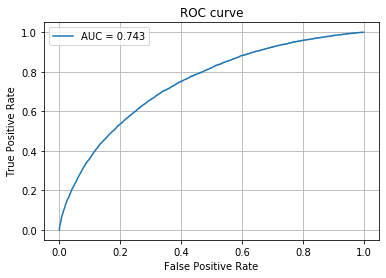

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

print('f1_score:',f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84717
           1       0.44      0.04      0.07      7537

    accuracy                           0.92     92254
   macro avg       0.68      0.52      0.52     92254
weighted avg       0.88      0.92      0.88     92254



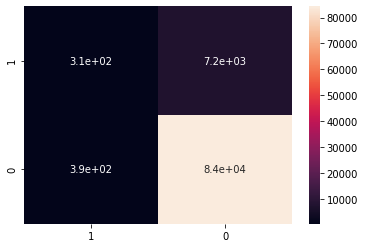

In [22]:
classes = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=classes)

cmdf = pd.DataFrame(cm, index=classes, columns=classes)

sns.heatmap(cmdf, annot=True)

print(classification_report(y_test, y_pred))

In [26]:
X_submit = X_total[train_rows:]
X_submit = std.fit_transform(X_submit)

y_proba_submit = clf.predict_proba(X_submit)[: , 1]
y_pred_submit = clf.predict(X_submit)

df_submit = pd.DataFrame(y_pred_submit, index=SK_ID_CURR, columns=['TARGET'])
df_submit.to_csv('homecredit_xgboost.csv')

print(df_submit.shape)
print(df_submit['TARGET'].sum())
xgb_hold_submit.head(10)

(48744, 1)
287


,TARGET
SK_ID_CURR,
100001,0
100005,0
100013,0
100028,0
100038,0
100042,0
100057,0
100065,0
100066,0


Kaggle score: 0.50529